## Cosine Annealing from scratch

Jeremy Assigned homework as part of Lesson 18 to implement the cosine annealing lr scheduler from scratch.  This is my attempt at creating a simple version using the formula found on the pytorch docs for cosine annealing.  Comparing against the pytorch implementation I can see that mine produces the same lr curve using our Recorder callback.

In [1]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import*

/home/joey/mambaforge/envs/fastai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle,gzip,math,os,time,shutil,torch
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4) # Data loader created with normalizer transform

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [6]:
np.array([0.02]) - 0.01

array([0.01])

In [7]:
(1 + math.cos(math.pi * (30 / 140)))

1.78183148246803

In [8]:
class CosineAnnealing():
    def __init__(self, optimizer, T_max): 
        fc.store_attr()
        self.lr_min = 0
        self.lr_max = np.array([group['lr'] for group in optimizer.param_groups])
        print(self.lr_max)
        self.current = 0
    def getLR(self):
        if(self.current > self.T_max): raise Exception("beyond T_max")
        newLr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * \
            (1 + math.cos(math.pi * (self.current / self.T_max)))
        return newLr

    def step(self): 
        newLr = self.getLR()
        for (group, lr) in zip(self.optimizer.param_groups, newLr):
            group['lr'] = lr
            
        self.current = self.current + 1


In [13]:
def _lr(cb): return cb.pg['lr']
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)
# sched = partial(CosineAnnealing, T_max=tmax)

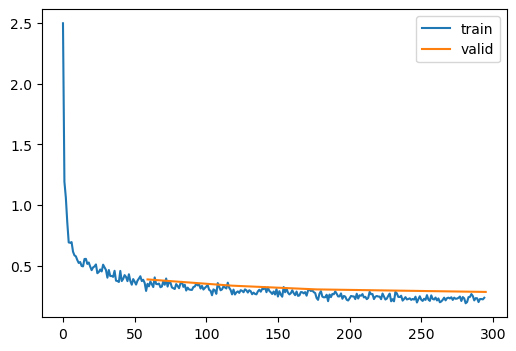

In [14]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

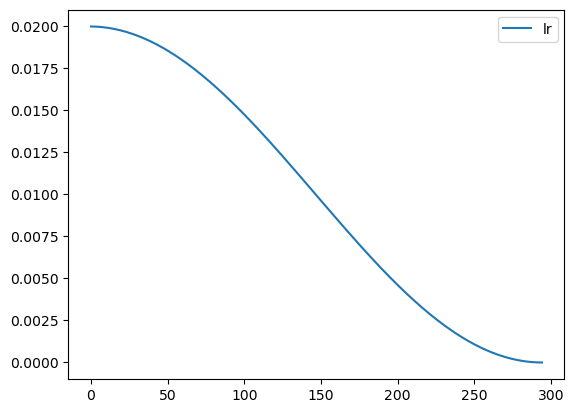

In [15]:
rec.plot()

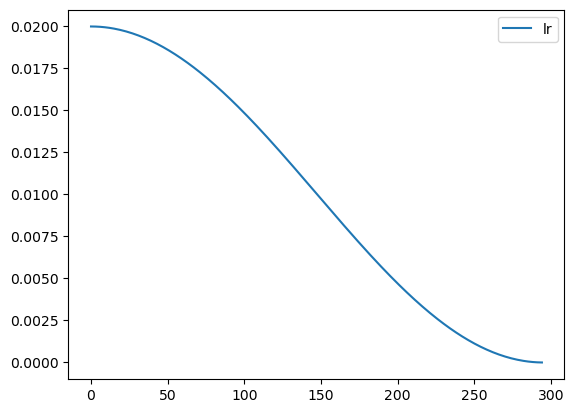

In [12]:
rec.plot()